In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from itertools import cycle
from fastai.vision import *
from fastai.metrics import *

torch.manual_seed(121)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(121)

In [3]:
train_csv = Path('/home/amey/LTTS/data/train-u1.csv')
valid_csv = Path('/home/amey/LTTS/data/valid.csv')

ALL_LBLS = ['No Finding',
            'Cardiomegaly',
            'Edema',
            'Consolidation',
            'Atelectasis',
            'Pleural Effusion',
            'Enlarged Cardiomediastinum',
            'Lung Opacity',
            'Lung Lesion',
            'Pneumonia',
            'Pneumothorax',
            'Pleural Other',
            'Fracture',
            'Support Devices']

EVAL_LBLS = ['Cardiomegaly',
             'Edema',
             'Consolidation',
             'Atelectasis',
             'Pleural Effusion',]

BS = 32
IMG_SZ = 224
IMG_MEAN = torch.FloatTensor([0.5027, 0.5027, 0.5027])
IMG_STD = torch.FloatTensor([0.2915, 0.2915, 0.2915])

GPU_IDS = [5]
torch.cuda.set_device(5)

TRN_WTS = torch.FloatTensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]).to('cuda:'+str(GPU_IDS[0]))

EXP = 'fastai-weighted-densenet-224-u1'
RES_DIR = 'results/'+EXP+'/'
os.makedirs('results/', exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

In [4]:
data_tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

train = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=train_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=0, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

valid = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=valid_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=1, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

data = DataBunch.create(train_ds=train.train_ds, valid_ds=valid.valid_ds, bs=BS)

data

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


DataBunch;

Train: LabelList (223414 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
No Finding;Support Devices,Cardiomegaly;Edema;Consolidation;Atelectasis;Pleural Effusion;Lung Opacity;Fracture,Consolidation;Lung Opacity;Fracture,Consolidation;Lung Opacity;Fracture,Edema
Path: /home1/amey/CheXpert-v1.0-downsampled;

Valid: LabelList (234 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
Atelectasis;Lung Opacity;Support Devices,No Finding,Cardiomegaly;Enlarged Cardiomediastinum,Edema;Consolidation;Atelectasis;Pleural Effusion;Enlarged Cardiomediastinum;Lung Opacity,Lung Opacity;Support Devices
Path: /home1/amey/CheXpert-v1.0-downsampled;

Test: None

In [ ]:
# print(data.train_ds)
# print(data.valid_ds)
doc(DataBunch.create)

In [4]:
from sklearn.metrics import roc_curve, auc

class AUC(Callback):

    def __init__(self, num_cl=14, pick='micro', plot_auc=False, plot_title=EXP+' - validation AUC', plot_path=RES_DIR+'valid_ROC_AUC.png'):
        self.id_to_class = {
            0: 'No Finding',
            1: 'Cardiomegaly',
            2: 'Edema',
            3: 'Consolidation',
            4: 'Atelectasis',
            5: 'Pleural Effusion',
            6: 'Enlarged Cardiomediastinum',
            7: 'Lung Opacity',
            8: 'Lung Lesion',
            9: 'Pneumonia',
            10: 'Pneumothorax',
            11: 'Pleural Other',
            12: 'Fracture',
            13: 'Support Devices',
            'micro': 'micro',
            'macro': 'macro',
        }
        self.name = str(self.id_to_class[pick])+'-AUC'
        self.pick = pick
        self.num_cl = num_cl
        self.plot_path = plot_path
        self.plot_title = plot_title
        self.plot_auc = plot_auc
        
    
    def on_epoch_begin(self, **kwargs):
        self.outputs, self.targets = [], []
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.outputs.append(last_output)
        self.targets.append(last_target)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        self.outputs = torch.sigmoid(torch.cat(self.outputs)).cpu().detach().numpy()
        self.targets = torch.cat(self.targets).cpu().numpy()
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(self.num_cl):
          fpr[i], tpr[i], _ = roc_curve(self.targets[:, i], self.outputs[:, i])
          roc_auc[self.id_to_class[i]] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        self.targets, self.outputs = self.targets[:,1:6], self.outputs[:,1:6]
        fpr["micro"], tpr["micro"], _ = roc_curve(self.targets.ravel(), self.outputs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,6)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(1,6):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= 5

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        if self.plot_auc:
            # Plot all ROC curves
            plt.figure()
            plt.plot(fpr["micro"], tpr["micro"],
                     label='micro (auc- {0:0.2f})'.format(roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=2)

            plt.plot(fpr["macro"], tpr["macro"],
                     label='macro (auc- {0:0.2f})'.format(roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=2)

            colors = cycle(['blue', 'green', 'red', 'cyan', 'yellow', 'magenta', 'black'])
            for i, color in zip(range(12), colors):
                if roc_auc[self.id_to_class[i]] > 0:
                    plt.plot(fpr[i], tpr[i], color=color, lw=1,
                         label='{0} (auc- {1:0.2f})'.format(self.id_to_class[i], roc_auc[self.id_to_class[i]]))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('{}'.format(self.plot_title))
            plt.legend(loc="lower right")
            plt.savefig(self.plot_path)
            print('roc-auc curve saved to {}'.format(self.plot_path))
        
        return add_metrics(last_metrics, roc_auc[self.id_to_class[self.pick]])

acc_02 = partial(accuracy_thresh, thresh=0.4)

In [6]:
learn = cnn_learner(data, models.densenet121, loss_func=nn.BCEWithLogitsLoss(weight=TRN_WTS),
                    metrics=[acc_02, AUC(pick=1), AUC(pick=2), AUC(pick=3), AUC(pick=4), AUC(pick=5), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png')])
learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


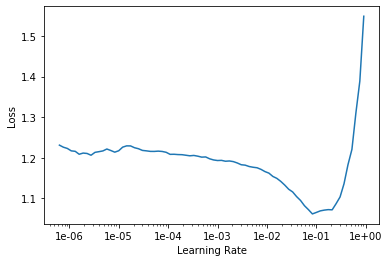

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.420391,0.442863,0.861111,0.791017,0.899588,0.880446,0.840909,0.929752,0.840275,23:06
1,0.410034,0.421878,0.862943,0.815999,0.919694,0.876979,0.825162,0.940388,0.845058,23:20


/home/amey/.conda/envs/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc-auc curve saved to results/fastai-weighted-densenet-224-u1/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-weighted-densenet-224-u1/valid_ROC_AUC.png


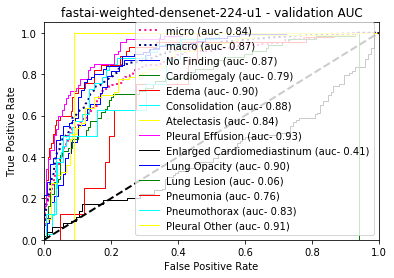

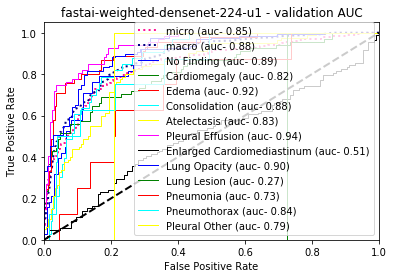

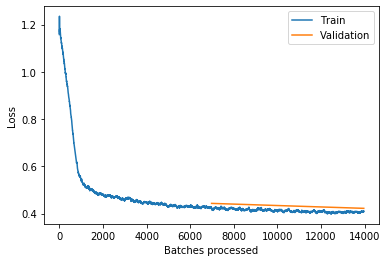

In [8]:
learn.unfreeze()
learn.fit_one_cycle(2)
learn.recorder.plot_losses()
learn.save(EXP+'-stage-1')

[autoreload of certifi failed: Traceback (most recent call last):
  File "/home/amey/.conda/envs/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/amey/.conda/envs/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/amey/.conda/envs/venv/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/amey/.conda/envs/venv/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/amey/.conda/envs/venv/lib/python3.6/site-packages/certifi/__init__.py", line 1, in <module>
    from .core import contents, where
ImportError: cannot

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


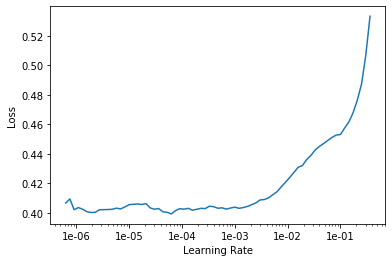

In [9]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.402806,0.417507,0.865385,0.821403,0.925456,0.877130,0.838312,0.933149,0.852188,23:12
1,0.396401,0.416631,0.865995,0.807672,0.922281,0.875773,0.837581,0.936277,0.852289,23:16


roc-auc curve saved to results/fastai-weighted-densenet-224-u1/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-weighted-densenet-224-u1/valid_ROC_AUC.png


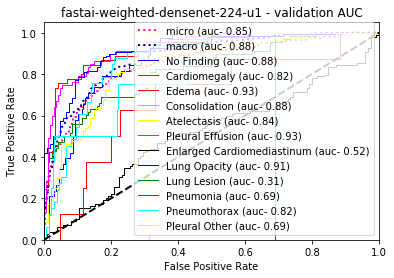

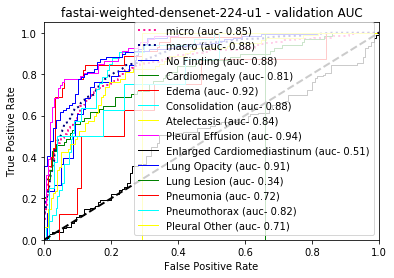

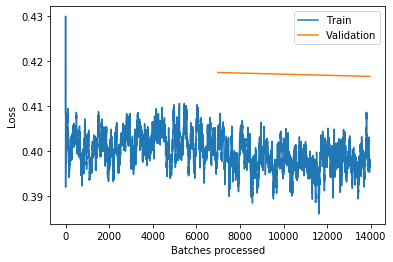

In [10]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(3*1e-5,1e-4))
learn.recorder.plot_losses()
learn.save(EXP+'-stage-2')

In [ ]:
# learn.validate(valid.valid_dl)

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


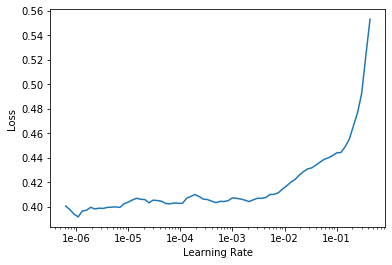

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [5]:
BS = 32
IMG_SZ = 320
IMG_MEAN = torch.FloatTensor([0.5027, 0.5027, 0.5027])
IMG_STD = torch.FloatTensor([0.2915, 0.2915, 0.2915])
GPU_IDS = [5]
torch.cuda.set_device(5)

EXP = 'fastai-weighted-densenet-320-u1'
RES_DIR = 'results/'+EXP+'/'
os.makedirs('results/', exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

data_tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

train = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=train_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=0, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

valid = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=valid_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=1, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

data = DataBunch.create(train_ds=train.train_ds, valid_ds=valid.valid_ds, bs=BS)

data

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


DataBunch;

Train: LabelList (223414 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
No Finding;Support Devices,Cardiomegaly;Edema;Consolidation;Atelectasis;Pleural Effusion;Lung Opacity;Fracture,Consolidation;Lung Opacity;Fracture,Consolidation;Lung Opacity;Fracture,Edema
Path: /home1/amey/CheXpert-v1.0-downsampled;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
Atelectasis;Lung Opacity;Support Devices,No Finding,Cardiomegaly;Enlarged Cardiomediastinum,Edema;Consolidation;Atelectasis;Pleural Effusion;Enlarged Cardiomediastinum;Lung Opacity,Lung Opacity;Support Devices
Path: /home1/amey/CheXpert-v1.0-downsampled;

Test: None

In [6]:
learn = cnn_learner(data, models.densenet121, metrics=[acc_02, AUC(pick=1), AUC(pick=2), AUC(pick=3), AUC(pick=4), AUC(pick=5), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png', plot_title=EXP+' - validation AUC')])
# learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)
learn.load('fastai-weighted-densenet-224-u1-stage-1')

Learner(data=DataBunch;

Train: LabelList (223414 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
No Finding;Support Devices,Cardiomegaly;Edema;Consolidation;Atelectasis;Pleural Effusion;Lung Opacity;Fracture,Consolidation;Lung Opacity;Fracture,Consolidation;Lung Opacity;Fracture,Edema
Path: /home1/amey/CheXpert-v1.0-downsampled;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
Atelectasis;Lung Opacity;Support Devices,No Finding,Cardiomegaly;Enlarged Cardiomediastinum,Edema;Consolidation;Atelectasis;Pleural Effusion;Enlarged Cardiomediastinum;Lung Opacity,Lung Opacity;Support Devices
Path: /home1/amey/CheXpert-v1.0-downsampled;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


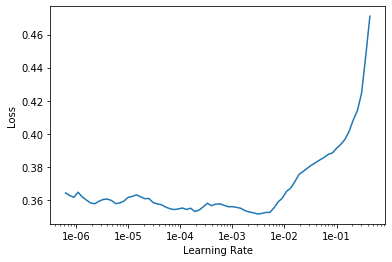

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.335849,0.336648,0.865995,0.800673,0.913815,0.875471,0.840341,0.949325,0.856430,38:53
1,0.336986,0.341888,0.862637,0.806609,0.924750,0.884065,0.836769,0.938422,0.845685,39:03


/home/amey/.conda/envs/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc-auc curve saved to results/fastai-weighted-densenet-320-u1/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-weighted-densenet-320-u1/valid_ROC_AUC.png


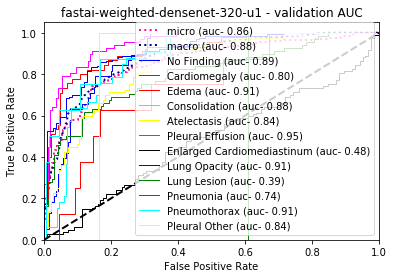

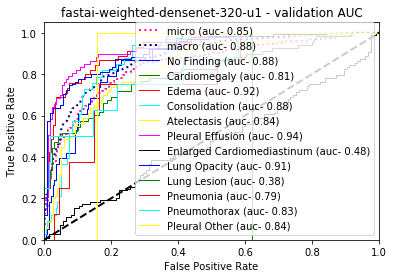

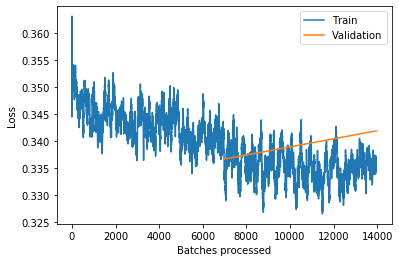

In [8]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,3*1e-4))
learn.recorder.plot_losses()
learn.save(EXP+'-stage-1')

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


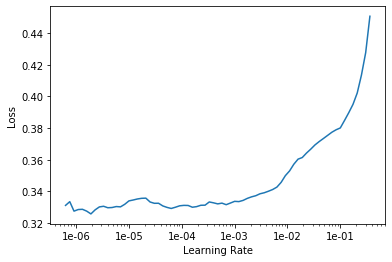

In [9]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.332019,0.338717,0.866911,0.807229,0.930276,0.885874,0.852029,0.936634,0.855297,38:28
1,0.328752,0.337139,0.864774,0.806166,0.926044,0.879994,0.841721,0.937170,0.853986,38:50


roc-auc curve saved to results/fastai-weighted-densenet-320-u1/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-weighted-densenet-320-u1/valid_ROC_AUC.png


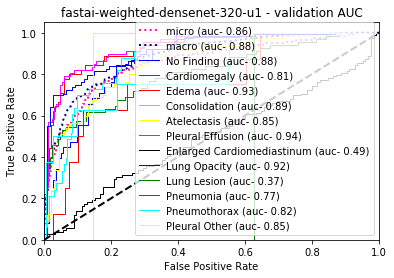

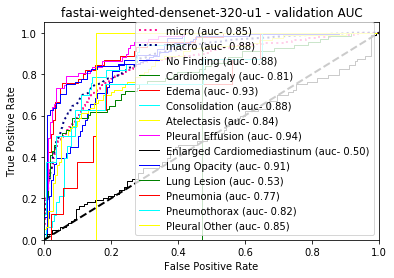

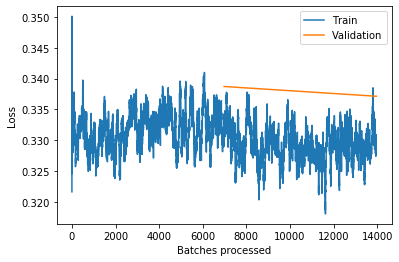

In [10]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(3*1e-5,8*1e-5))
learn.recorder.plot_losses()
learn.save(EXP+'-stage-2')

In [ ]:
learn = cnn_learner(data, models.densenet121, metrics=[acc_02, AUC(pick=1), AUC(pick=2), AUC(pick=3), AUC(pick=4), AUC(pick=5), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png', plot_title=EXP+' - validation AUC')])
learn.load('fastai-densenet-320-u1-stage-2')

In [ ]:
learn.validate(data.valid_dl)